# Preprocessing LTS files
In this script we will load the LTS files and inspect the data.

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from shutil import copy2
from Definitions import LTS_DIR, LTS_IMPROVED
from HelperFunctions import printProgressBar, loadObject, dumpObject 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 400)

In [3]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

## Parsing filename into cik, company and financial year.
In the following we will have a look at the available LTS text files, that we have. If all looks good, no preprocessing is needed. First let's search get all LTS filenames:

In [4]:
print("██████████████████████████████████ Using Original Data ██ Start █████████████████████████████")
all_files = glob.glob(str(LTS_DIR / r"*.txt"))
all_files[:5]

██████████████████████████████████ Using Original Data ██ Start █████████████████████████████


['E:\\00_git\\invact\\input_Data\\lts\\001075_PINNACLE WEST CAPITAL CORP_2000.txt',
 'E:\\00_git\\invact\\input_Data\\lts\\001075_PINNACLE WEST CAPITAL CORP_2001.txt',
 'E:\\00_git\\invact\\input_Data\\lts\\001075_PINNACLE WEST CAPITAL CORP_2002.txt',
 'E:\\00_git\\invact\\input_Data\\lts\\001075_PINNACLE WEST CAPITAL CORP_2004.txt',
 'E:\\00_git\\invact\\input_Data\\lts\\001075_PINNACLE WEST CAPITAL CORP_2005.txt']

As we can see, some important lts data is already included in the filename itself (delimiter: underscore). This includes:
* gvkey
* company name
* financial year

This is all the necessary data we need for now. Therefore, let's try to extract this information from the filename for all files. 

In [5]:
filename_gvkey_compName_finYear_data = []
for index, filename in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    file_basename = os.path.basename(filename)[:-4]
    file_basename_split = file_basename.split("_")
    file_basename_split.insert(0, filename)
    filename_gvkey_compName_finYear_data.append(file_basename_split)

Progress |██████████████████████████████████████████████████| 100.0% Complete


Let's now put the extracted information into a dataframe and investigate it.

In [6]:
df_LTS = pd.DataFrame(filename_gvkey_compName_finYear_data)
df_LTS

0  \
0     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2000.txt   
1     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2001.txt   
2     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2002.txt   
3     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2004.txt   
4     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2005.txt   
...                                                                          ...   
8347                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2014.txt   
8348                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2015.txt   
8349                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2016.txt   
8350                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2017.txt   
8351                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2018.txt   

           1                           2     3     4     5  
0     001075  PINNACLE WEST CAPITAL CORP  2000  None  None  
1     001075  PINNACLE WEST CAPITAL CORP  2001  None  None  
2     001075  PINNACLE WEST CAPITAL CORP  2002  None  None  
3     001075  PINNACLE WEST CAPITAL CORP  2004  None  None  
4     001075  PINNACLE WEST CAPITAL CORP  2005  None  None  
...      ...                         ...   ...   ...   ...  
8347  316056                ALLEGION PLC  2014  None  None  
8348  316056                ALLEGION PLC  2015  None  None  
8349  316056                ALLEGION PLC  2016  None  None  
8350  316056                ALLEGION PLC  2017  None  None  
8351  316056                ALLEGION PLC  2018  None  None  

[8352 rows x 6 columns]

### Correcting wrong company name
We can see, that we have 5 columns instead of the 3 columns, which we expected. Therefore we can suspect that at least one file does not adhere to the naming convention of seperating gvkey, company name and financial year by a *underscore* symbol.
Let's find these files and have a closer look at them.

In [7]:
df_problemFiles = df_LTS[df_LTS[4].notnull()]
df_problemFiles

0  \
4912  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2008.txt   
4913  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2009.txt   
4914  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2010.txt   
4915  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2011.txt   
4916  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2012.txt   
4917  E:\00_git\invact\input_Data\lts\013421_CADENCE_DESIGN_SYSTEMS_2013.txt   

           1        2       3        4     5  
4912  013421  CADENCE  DESIGN  SYSTEMS  2008  
4913  013421  CADENCE  DESIGN  SYSTEMS  2009  
4914  013421  CADENCE  DESIGN  SYSTEMS  2010  
4915  013421  CADENCE  DESIGN  SYSTEMS  2011  
4916  013421  CADENCE  DESIGN  SYSTEMS  2012  
4917  013421  CADENCE  DESIGN  SYSTEMS  2013

We see that in the case of the company Cadence Design Systems, there are underscore symbols between the different parts of the company name. This does not adhere to the naming convention.

We can adjust our data parser, by catching and correcting this case.

In [8]:
filename_gvkey_compName_finYear_data = []
for index, filename in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    with open(filename, encoding = "utf-8") as file:
        file_basename = os.path.basename(filename)[:-4]
        file_basename_split = file_basename.split("_")
        if len(file_basename_split) > 3: #Catching and correcting error case.
            file_basename_split = [file_basename_split[0]," ".join(file_basename_split[1:-1]),file_basename_split[-1]]
        file_basename_split.insert(0, filename)
        filename_gvkey_compName_finYear_data.append(file_basename_split)

Progress |██████████████████████████████████████████████████| 100.0% Complete


Let's now have a look at the data gathered by our improved algorithm:

In [9]:
df_LTS = pd.DataFrame(filename_gvkey_compName_finYear_data, columns=['lts_filePath','lts_gvkey', 'lts_company name', 'lts_finYear'])
df_LTS

lts_filePath  \
0     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2000.txt   
1     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2001.txt   
2     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2002.txt   
3     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2004.txt   
4     E:\00_git\invact\input_Data\lts\001075_PINNACLE WEST CAPITAL CORP_2005.txt   
...                                                                          ...   
8347                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2014.txt   
8348                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2015.txt   
8349                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2016.txt   
8350                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2017.txt   
8351                E:\00_git\invact\input_Data\lts\316056_ALLEGION PLC_2018.txt   

     lts_gvkey            lts_company name lts_finYear  
0       001075  PINNACLE WEST CAPITAL CORP        2000  
1       001075  PINNACLE WEST CAPITAL CORP        2001  
2       001075  PINNACLE WEST CAPITAL CORP        2002  
3       001075  PINNACLE WEST CAPITAL CORP        2004  
4       001075  PINNACLE WEST CAPITAL CORP        2005  
...        ...                         ...         ...  
8347    316056                ALLEGION PLC        2014  
8348    316056                ALLEGION PLC        2015  
8349    316056                ALLEGION PLC        2016  
8350    316056                ALLEGION PLC        2017  
8351    316056                ALLEGION PLC        2018  

[8352 rows x 4 columns]

As we can now see, our algorithm successfully caught all the corrupted filenames and corrected them. Let's now further investigate this data.

## Removing duplicates
For each specific year and gvkey, there must only be at max 1 entry. (*(fin_year, gvkey)* is a **unique identifier** for a LTS)

Let's check if this is the case:

In [10]:
duplicates  = pd.concat(g for _, g in df_LTS.groupby(["lts_gvkey", "lts_finYear"]) if len(g) > 1)
duplicates.sort_values(["lts_gvkey", "lts_finYear"])

lts_filePath  \
821   E:\00_git\invact\input_Data\lts\002968_JP MORGAN CHASE & CO._2017.txt   
839     E:\00_git\invact\input_Data\lts\002968_JPMORGAN CHASE & CO_2017.txt   
2767             E:\00_git\invact\input_Data\lts\007257_MERCK & CO_2016.txt   
2768    E:\00_git\invact\input_Data\lts\007257_NEWMONT MINING CORP_2016.txt   
4356   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2010.txt   
4365          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2010.txt   
4357   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2011.txt   
4366          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2011.txt   
4358   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2012.txt   
4367          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2012.txt   
4359   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2013.txt   
4368          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2013.txt   
4360   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2014.txt   
4369          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2014.txt   
4361   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2015.txt   
4370          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2015.txt   
4362   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2016.txt   
4371          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2016.txt   
4363   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2017.txt   
4372          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2017.txt   
4364   E:\00_git\invact\input_Data\lts\011399_WESTERN DIGITAL CORP_2018.txt   
4373          E:\00_git\invact\input_Data\lts\011399_WESTERN UNION_2018.txt   
5011         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2008.txt   
5024  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2008.txt   
5012         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2009.txt   
5025  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2009.txt   
5013         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2010.txt   
5026  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2010.txt   
5014         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2011.txt   
5027  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2011.txt   
5015         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2012.txt   
5028  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2012.txt   
5016         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2013.txt   
5029  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2013.txt   
5017         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2014.txt   
5030  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2014.txt   
5018         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2015.txt   
5031  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2015.txt   
5019         E:\00_git\invact\input_Data\lts\013988_CHARLES SCHWAB_2016.txt   
5032  E:\00_git\invact\input_Data\lts\013988_SCHWAB (CHARLES) CORP_2016.txt   
8312     E:\00_git\invact\input_Data\lts\260774_CBRE GROUP CLASS A_2017.txt   
8325         E:\00_git\invact\input_Data\lts\260774_CBRE GROUP INC_2017.txt   

     lts_gvkey       lts_company name lts_finYear  
821     002968  JP MORGAN CHASE & CO.        2017  
839     002968    JPMORGAN CHASE & CO        2017  
2767    007257             MERCK & CO        2016  
2768    007257    NEWMONT MINING CORP        2016  
4356    011399   WESTERN DIGITAL CORP        2010  
4365    011399          WESTERN UNION        2010  
4357    011399   WESTERN DIGITAL CORP        2011  
4366    011399          WESTERN UNION        2011  
4358    011399   WESTERN DIGITAL CORP        2012  
4367    011399          WESTERN UNION        2012  
4359    011399   WESTERN DIGITAL CORP        2013  
4368    011399          WESTERN UNION    

In [11]:
print(f"There are {len(duplicates)} entries in the data, that are not unique.")

There are 42 entries in the data, that are not unique.


We see, that 42 entries in the data are not unique. Let's investigate these cases further. 

* In the first case, we see that there are two entries for *JPMORGAN CHASE & CO*, where the company name differs. The corresponding text files also slightly differ in their content. *002968_JPMORGAN CHASE & CO_2017.txt* contains only the LTS, while *002968_JP MORGAN CHASE & CO._2017.txt* contains the LTS and additional data, which we do not need for further analysis. We therefore decide to drop the latter file from our data set.
* In the second case, we see that we have two different company names for the same financial year and gvkey. If we check our Compustat data, we see, that the given gvkey (7257) belongs to the company *MERCK & CO* and not to the company *NEWMONT MINING CORP*, whose gvkey is 7881. Therfore, the latter file was falsely attributed to the the gvkey 7257. When we look into the LTS dataset, we see that there is already a LTS for the pair (gvkey = 7257, fin_year = 2016). When we compare these two LTS files, we see that these are duplicates. We can therefore drop the LTS with the wrong gvkey from our dataset. 
* In the third case, we see the two companies *WESTERN DIGITAL CORP* and *WESTERN UNION* under the same gvkey (011399). If we check our compustat data, we see that the given gvkey corresponds to the *Western Digital Corporation*. *Western Union's* gvkey is 175263. When we look into the LTS dataset, we see that there are already LTS files for the *Western Union* under the gvkey 175263. However, there is none for the year 2017. Therefore, we can drop all the *Western Union* that were assigned the wrong gvkey, with the exception of the one LTS for 2017. This file will be renamed accordingly.
* In the fourth case, we see the two companies *CHARLES SCHWAB* and *SCHWAB (CHARLES) CORP* under the same gvkey (13988). If we check our compustat data, we see that the given gvkey corresponds to the *SCHWAB (CHARLES) CORP*. After investigating the corresponding text files and consolidating the compustat data, we conclude that these two different company names actually do correspond to the same company. Because the text files for *CHARLES SCHWAB* sometimes seem to be of higher quality (less broken words and characters), we will keep these files and drop the other files (corresponding to *SCHWAB (CHARLES) CORP*) from our sample.
* In the fifth case, we seem to have the same LTS for two data points. We will drop the first data point, as the official name of the company is *CBRE GROUP INC*. *CBRE GROUP CLASS A* probably corresponds to the specific kind of shareholders (class A shareholders).

Instead of only correcting these errors in our representation of the data (dataframe), we will correct the underlying data itself. This will enable future researches to work with our improved data set.
However, because we still want to enable other researches to follow our steps **here**, we will also keep the original data set as a back up. This means that instead of removing the duplicates from the existing directory and changing file names accordingly, we will create a new folder, to which we will copy the corrected data.
The improved data set, which will be used for all the subsequent steps in this work, will be stored in the following directory: 

In [12]:
print(LTS_IMPROVED)

E:\00_git\invact\internal_Data\lts_improved_data_set


Let's first start by correcting the naming error identified at the beginning of this page.

In [13]:
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2008.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2008.txt")
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2009.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2009.txt")
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2010.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2010.txt")
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2011.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2011.txt")
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2012.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2012.txt")
copy2(LTS_DIR / "013421_CADENCE_DESIGN_SYSTEMS_2013.txt", LTS_IMPROVED / "013421_CADENCE DESIGN SYSTEMS_2013.txt")
do_not_copy = []
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2008.txt")
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2009.txt")
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2010.txt")
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2011.txt")
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2012.txt")
do_not_copy.append("013421_CADENCE_DESIGN_SYSTEMS_2013.txt")

Now, let's make sure that the following files are not copied to the improved data set.
* *002968_JP MORGAN CHASE & CO._2017.txt* (case 1)
* *007257_NEWMONT MINING CORP_2016.txt* (case 2)
* *011399_WESTERN DIGITAL CORP_201[X].txt* (case 3, with X ranging from 0-8, with the exception of 7. This file will be renamed and then copied to the improved dataset.
* *013988_SCHWAB (CHARLES) CORP_20[XY].txt* (case 4, with XY ranging from 08 to 16) 
* *260774_CBRE GROUP CLASS A_2017.txt* (case 5)

In [14]:
do_not_copy.append("002968_JP MORGAN CHASE & CO._2017.txt")
do_not_copy.append("007257_NEWMONT MINING CORP_2016.txt")
do_not_copy.append("011399_WESTERN UNION_2010.txt")
do_not_copy.append("011399_WESTERN UNION_2011.txt")
do_not_copy.append("011399_WESTERN UNION_2012.txt")
do_not_copy.append("011399_WESTERN UNION_2013.txt")
do_not_copy.append("011399_WESTERN UNION_2014.txt")
do_not_copy.append("011399_WESTERN UNION_2015.txt")
do_not_copy.append("011399_WESTERN UNION_2016.txt")
do_not_copy.append("011399_WESTERN UNION_2017.txt") #a renamed file will be copied to the improved data set.
do_not_copy.append("011399_WESTERN UNION_2018.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2008.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2009.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2010.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2011.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2012.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2013.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2014.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2015.txt")
do_not_copy.append("013988_SCHWAB (CHARLES) CORP_2016.txt")
do_not_copy.append("260774_CBRE GROUP CLASS A_2017.txt")

copy2(LTS_DIR / "011399_WESTERN UNION_2017.txt", LTS_IMPROVED / "175263_WESTERN UNION CO_2017.txt")

WindowsPath('E:/00_git/invact/internal_Data/lts_improved_data_set/175263_WESTERN UNION CO_2017.txt')

Now, that we have copied some  modified LTS files to the new directory, let's copy all the files from the original dataset to the new directory with these two exceptions:
* Files that need to be removed from data set.
* Files that have already been copied to the new directory in a modified form.

All files that correspond to either one of these two cases are saved in the list *do_not_copy*.

In [15]:
all_files = df_LTS["lts_filePath"].values
for index, file in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    if Path(file).name not in do_not_copy:
        copy2(file, LTS_IMPROVED / Path(file).name)

Progress |█-------------------------------------------------| 2.6% Complete

Progress |██------------------------------------------------| 5.3% Complete

Progress |███-----------------------------------------------| 8.0% Complete

Progress |█████---------------------------------------------| 10.7% Complete

Progress |███████-------------------------------------------| 16.0% Complete

Progress |██████████----------------------------------------| 21.3% Complete

Progress |█████████████-------------------------------------| 26.0% Complete

Progress |██████████████------------------------------------| 28.5% Complete

Progress |███████████████-----------------------------------| 31.0% Complete

Progress |████████████████----------------------------------| 33.8% Complete

Progress |███████████████████-------------------------------| 39.3% Complete

Progress |████████████████████------------------------------| 42.0% Complete

Progress |████████████████████████--------------------------| 49.7% Complete

Progress |███████████████████████████-----------------------| 55.0% Complete

Progress |████████████████████████████----------------------| 57.8% Complete

Progress |██████████████████████████████--------------------| 60.6% Complete

Progress |███████████████████████████████-------------------| 63.4% Complete

Progress |█████████████████████████████████-----------------| 66.1% Complete

Progress |██████████████████████████████████----------------| 68.9% Complete

Progress |███████████████████████████████████---------------| 71.5% Complete

Progress |█████████████████████████████████████-------------| 74.1% Complete

Progress |███████████████████████████████████████-----------| 79.1% Complete

Progress |████████████████████████████████████████----------| 81.8% Complete

Progress |██████████████████████████████████████████--------| 84.4% Complete

Progress |███████████████████████████████████████████-------| 87.0% Complete

Progress |████████████████████████████████████████████------| 89.7% Complete

Progress |██████████████████████████████████████████████----| 92.5% Complete

Progress |███████████████████████████████████████████████---| 95.1% Complete

Progress |████████████████████████████████████████████████--| 97.8% Complete

Progress |██████████████████████████████████████████████████| 100.0% Complete


## Rerun - Parsing filename into cik, company and financial year.
Now that we have a improved data sample, let's rerun our parsing algorithm from the beginning of the page.
As we have also fixed the files, where the naming convention was not adhered, we can use the simpler algorithm for parsing the data.

In [16]:
all_files = glob.glob(str(LTS_IMPROVED / r"*.txt"))
filename_gvkey_compName_finYear_data = []
for index, filename in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    file_basename = os.path.basename(filename)[:-4]
    file_basename_split = file_basename.split("_")
    file_basename_split.insert(0, filename)
    filename_gvkey_compName_finYear_data.append(file_basename_split)

Progress |████████████████----------------------------------| 32.5% Complete

Progress |███████████████████████████████-------------------| 62.1% Complete

Progress |██████████████████████████████████████████████████| 100.0% Complete


In [17]:
df_LTS = pd.DataFrame(filename_gvkey_compName_finYear_data, columns=['lts_filePath','lts_gvkey', 'lts_company name', 'lts_finYear'])
df_LTS

lts_filePath  \
0     E:\00_git\invact\internal_Data\lts_improved_data_set\001075_PINNACLE WEST CAPITAL CORP_2000.txt   
1     E:\00_git\invact\internal_Data\lts_improved_data_set\001075_PINNACLE WEST CAPITAL CORP_2001.txt   
2     E:\00_git\invact\internal_Data\lts_improved_data_set\001075_PINNACLE WEST CAPITAL CORP_2002.txt   
3     E:\00_git\invact\internal_Data\lts_improved_data_set\001075_PINNACLE WEST CAPITAL CORP_2004.txt   
4     E:\00_git\invact\internal_Data\lts_improved_data_set\001075_PINNACLE WEST CAPITAL CORP_2005.txt   
...                                                                                               ...   
8327                E:\00_git\invact\internal_Data\lts_improved_data_set\316056_ALLEGION PLC_2014.txt   
8328                E:\00_git\invact\internal_Data\lts_improved_data_set\316056_ALLEGION PLC_2015.txt   
8329                E:\00_git\invact\internal_Data\lts_improved_data_set\316056_ALLEGION PLC_2016.txt   
8330                E:\00_git\invact\internal_Data\lts_improved_data_set\316056_ALLEGION PLC_2017.txt   
8331                E:\00_git\invact\internal_Data\lts_improved_data_set\316056_ALLEGION PLC_2018.txt   

     lts_gvkey            lts_company name lts_finYear  
0       001075  PINNACLE WEST CAPITAL CORP        2000  
1       001075  PINNACLE WEST CAPITAL CORP        2001  
2       001075  PINNACLE WEST CAPITAL CORP        2002  
3       001075  PINNACLE WEST CAPITAL CORP        2004  
4       001075  PINNACLE WEST CAPITAL CORP        2005  
...        ...                         ...         ...  
8327    316056                ALLEGION PLC        2014  
8328    316056                ALLEGION PLC        2015  
8329    316056                ALLEGION PLC        2016  
8330    316056                ALLEGION PLC        2017  
8331    316056                ALLEGION PLC        2018  

[8332 rows x 4 columns]

To check, wheather we really have no more duplicates now, let's rerun our algorithm from earlier:

In [18]:
try:
    duplicates  = pd.concat(g for _, g in df_LTS.groupby(["lts_gvkey", "lts_finYear"]) if len(g) > 1)
    duplicates.sort_values(["lts_gvkey", "lts_finYear"])
except Exception as e:
    print(e)

No objects to concatenate


As we can see, there are no more duplicates.

## Adjusting data types
We now want to make sure, that the columns within the dataframe have the right datatype assigned to them.
First, we check for the current datataypes:

In [19]:
df_LTS.dtypes

lts_filePath        object
lts_gvkey           object
lts_company name    object
lts_finYear         object
dtype: object

Let's change the data type of the gvkey and financial year to *numeric*.

In [20]:
df_LTS[["lts_gvkey","lts_finYear"]] = df_LTS[["lts_gvkey","lts_finYear"]].apply(pd.to_numeric)

Our data types are now the following:

In [21]:
df_LTS.dtypes

lts_filePath        object
lts_gvkey            int64
lts_company name    object
lts_finYear          int64
dtype: object

Our data has now the form that we want. We can therefore write the dataframe to the hard disk for later use.

In [22]:
dumpObject(df_LTS, "df_LTS")

## Descriptive Statistics
Let's get to know the LTS data a bit better.
### Financial years
Let's look at the *fin_year* year data.

In [23]:
df_LTS['lts_finYear'].value_counts().sort_index()

2000    168
2001    225
2002    255
2003    288
2004    301
2005    413
2006    477
2007    499
2008    524
2009    535
2010    549
2011    526
2012    538
2013    551
2014    503
2015    514
2016    504
2017    508
2018    454
Name: lts_finYear, dtype: int64

We can also visualize this data:

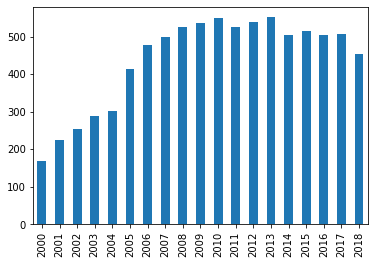

In [24]:
fig, ax = plt.subplots()
df_LTS['lts_finYear'].value_counts().sort_index().plot(ax=ax, kind='bar')

We can see, that we have data from the years 2000 to 2018. 
What we can also see, is that the number of datapoints tends to be larger in later years. For the year 2000 only 168 data points are present.

### Number of companies.

In [27]:
nr_of_distinct_companies = df_LTS["lts_gvkey"].nunique()
nr_of_toal_entries = df_LTS["lts_gvkey"].size
print(f"There are {str(nr_of_toal_entries)} files in the dataset.")
print(f"There are {str(nr_of_distinct_companies)} of companies in the dataset.")
print("Therefore, there are on average {:.2f} LTS per company.".format(nr_of_toal_entries/nr_of_distinct_companies))

There are 8332 files in the dataset.
There are 697 of companies in the dataset.
Therefore, there are on average 11.95 LTS per company.


## Summary
We loaded all the available LTS data. After we fixed a naming/parsing error, we analyzed the data and showed, that: 
  * the input data contained 8,352 data points.
  * the input data contained faulty files.
  * after correcting or removing these faulty files, we end up with a total of 8,332 usable data points
  * we have data for the years 2000-2018 (more data for later years, less data for earlier years)
  * we have 697 distinct companies in the data set (corresponds to 11.95 filings per company)